In [1]:
!pip install tensorflow==2.2.0
!pip install gpflow
!pip install gast
!pip install observations

     |████████████████████████████████| 235kB 2.7MB/s 
     |████████████████████████████████| 491kB 2.7MB/s 
  Created wheel for observations: filename=observations-0.1.4-cp36-none-any.whl size=1319270 sha256=ec296d2191947a3d5e53fa03834d2ca29471ce4b086c8e82286d8823a0534846
  Stored in directory: /root/.cache/pip/wheels/21/53/d7/c4d7a5cab86d07b083ebb2e417dcd0cb2bf5dd8c440af675d7
Successfully built observations


In [0]:
from typing import Tuple, Optional
import tempfile
import pathlib

import datetime
import io
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import gpflow

import matplotlib.pyplot as plt

from gpflow.config import default_float, default_jitter
from gpflow.ci_utils import ci_niter
from gpflow.utilities import to_default_float
from gpflow.base import TensorLike
from gpflow import covariances as cov
from gpflow import kullback_leiblers as kl
from gpflow.covariances import Kuu
from gpflow.covariances import Kuf

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import csv
import numpy as np
import os
import sys
from shutil import copyfile, rmtree
import pickle

import observations

import warnings

warnings.filterwarnings("ignore")
sys.path.insert(0,'./VFF/')

import VFF_IV

Make `tensorboard` work inside notebook:

In [0]:
output_logdir = "/tmp/tensorboard"

!rm -rf "{output_logdir}"
!mkdir "{output_logdir}"

%load_ext tensorboard
%matplotlib inline


def enumerated_logdir(_logdir_id: int = [0]):
    logdir = pathlib.Path(output_logdir, str(_logdir_id[0]))
    _logdir_id[0] += 1
    return str(logdir)

Set up random seeds and default float for `gpflow` tensors:

In [0]:
gpflow.config.set_default_float(np.float64)
np.random.seed(0)
tf.random.set_seed(0)

## Loading the snelson dataset

In [0]:
'''
  This code was copied from https://github.com/edwardlib/observations/blob/master/observations/snelson1d.py
  on 01/05/2020
'''

from observations.util import maybe_download_and_extract


def snelson1d(path):
  """Load Edward Snelson's 1d regression data set [@snelson2006fitc].
  It contains 200 examples of a few oscillations of an example function. It has
  seen extensive use as a toy dataset for illustrating qualitative behaviour of
  Gaussian process approximations.
  Args:
    path: str.
      Path to directory which either stores file or otherwise file will be
      downloaded and extracted there. Filenames are `snelson_train_*`.
  Returns:
    Tuple of two np.darray `inputs` and `outputs` with 200 rows and 1 column.
  """
  path = os.path.expanduser(path)
  inputs_path = os.path.join(path, 'snelson_train_inputs')
  outputs_path = os.path.join(path, 'snelson_train_outputs')

  # Contains all source as well. We just need the data.
  url = 'http://www.gatsby.ucl.ac.uk/~snelson/SPGP_dist.zip'

  if not (os.path.exists(inputs_path) and os.path.exists(outputs_path)):
    maybe_download_and_extract(path, url)

    # Copy the required data
    copyfile(os.path.join(path, "SPGP_dist", "train_inputs"), inputs_path)
    copyfile(os.path.join(path, "SPGP_dist", "train_outputs"), outputs_path)

    # Clean up everything else
    rmtree(os.path.join(path, "SPGP_dist"))
    os.remove(os.path.join(path, "SPGP_dist.zip"))

  X = np.loadtxt(os.path.join(inputs_path))[:, None]
  Y = np.loadtxt(os.path.join(outputs_path))[:, None]

  return X, Y

In [6]:
X, Y = snelson1d(".")
num_train_data = X.shape[0]

>> Downloading ./SPGP_dist.zip.part 
>> [14.7 KB/14.7 KB] 6944% @3.7 MB/s,[0s remaining, 0s elapsed]        
URL http://www.gatsby.ucl.ac.uk/~snelson/SPGP_dist.zip downloaded to ./SPGP_dist.zip 


Working with TensorFlow Datasets is an efficient way to rapidly shuffle, iterate, and batch from data. For `prefetch` size we use `tf.data.experimental.AUTOTUNE` as recommended by TensorFlow [guidelines](https://www.tensorflow.org/guide/data_performance).

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y))

batch_size = 32
num_features = 10
prefetch_size = tf.data.experimental.AUTOTUNE
shuffle_buffer_size = num_train_data // 2
num_batches_per_epoch = num_train_data // batch_size

original_train_dataset = train_dataset
train_dataset = (
    train_dataset.repeat()
    .prefetch(prefetch_size)
    .shuffle(buffer_size=shuffle_buffer_size)
    .batch(batch_size)
)

print(f"prefetch_size={prefetch_size}")
print(f"shuffle_buffer_size={shuffle_buffer_size}")
print(f"num_batches_per_epoch={num_batches_per_epoch}")

prefetch_size=-1
shuffle_buffer_size=100
num_batches_per_epoch=6


In [0]:
from gpflow.conditionals import conditional

def plot(Xtest, models):

  for (mean, std, meanColour, stdColour) in models:
    plt.plot(Xtest, mean, color=meanColour)

    plt.plot(Xtest, mean + std, color=stdColour)
    plt.plot(Xtest, mean - std, color=stdColour)
    plt.fill_between(np.squeeze(Xtest), np.squeeze(mean + std), np.squeeze(mean - std), color=stdColour, alpha=0.2)
  

  plt.scatter(X, Y, s=15)

  plt.show()



## Define a GP model

In GPflow 2.0, we use `tf.Module` (or the very thin `gpflow.base.Module` wrapper) to build all our models, as well as their components (kernels, likelihoods, parameters, and so on).

### 1D Random Variational Fourier Feature Class

In [0]:
class RVFF_1D(gpflow.inducing_variables.InducingVariables):
    def __init__(self, a, b, M):
        self.length = M
        # [a, b] defining the interval of the Fourier representation:
        self.a = gpflow.Parameter(a, dtype=gpflow.default_float())
        self.b = gpflow.Parameter(b, dtype=gpflow.default_float())

        self.phis = gpflow.Parameter(np.random.uniform(0, 2 * np.pi, size=M))
        var = 200
        mean = 30
        self.omegas = gpflow.Parameter(np.random.uniform(0, 150, size=M)) # np.random.multivariate_normal(mean=mean * np.ones(M), cov = var * np.identity(M)) #np.arange(1, 201, 1, dtype=default_float())  # 

    def __len__(self):
        """ number of inducing variables (defines dimensionality of q(u)) """ 
        return self.length  # M sine components

In [0]:
@cov.Kuu.register(RVFF_1D, gpflow.kernels.Matern12)
def Kuu_matern12_RVFF_1D(inducing_variable, kernel, jitter=None):
    a, b, omegas, phis = (lambda u: (u.a, u.b, u.omegas, u.phis))(inducing_variable)
    
    lambda_ = 1.0 / kernel.lengthscales
    
    def innerProduct( intervalLen, omegas, phis, kernelVar, lambda_):
      angle1 = intervalLen * ( omegas[:, None] - omegas[None, :] ) + omegas[:, None] * phis[:, None] - omegas[None, :] * phis[None, :]
      angle2 = intervalLen * ( omegas[:, None] + omegas[None, :] ) + omegas[:, None] * phis[:, None] + omegas[None, :] * phis[None, :]
      angle3 = omegas[:, None] * phis[:, None] - omegas[None, :] * phis[None, :]
      angle4 = omegas[:, None] * phis[:, None] + omegas[None, :] * phis[None, :]
      angle5 = omegas * ( 2 * intervalLen + phis[:, None] + phis[None, :] )
      angle6 = omegas * (phis[:, None] + phis[None, :])

      denom1 = tf.Variable(omegas[:, None] - omegas[None, :])
      denom2 = tf.Variable(omegas[:, None] + omegas[None, :])
      denom3 = tf.Variable(2 * omegas)

      denom1 = tf.where(denom1 == 0, 1.0, denom1)
      denom2 = tf.where(denom2 == 0, 1.0, denom2)
      denom3 = tf.where(denom3 == 0, 1.0, denom3)
      
      coeff1 = ( omegas[:, None] * omegas[None, :] + lambda_ * lambda_ ) / denom1 
      coeff2 = ( omegas[:, None] * omegas[None, :] - lambda_ * lambda_ ) / denom2 #( omegas[:, None] + omegas[None, :] )
      coeff3 = ( omegas * omegas - lambda_ * lambda_ ) / denom3
      coeff4 = -coeff3
      coeff5 = lambda_ * lambda_ + omegas * omegas

      denom = 4  * kernelVar * lambda_

      firstTerm = ( coeff1 * tf.sin( angle1 ) +
                    coeff2 * tf.sin( angle2 ) -
                    lambda_ * tf.cos( angle2 ) +
                    lambda_ * tf.cos( angle1 ) -
                    coeff1 * tf.sin( angle3 ) -
                    coeff2 * tf.sin( angle4 ) +
                    lambda_ * tf.cos( angle4 ) -
                    lambda_ * tf.cos( angle3 ) ) / denom

      firstTermForEqualOmegas = ( ( omegas * omegas + lambda_ * lambda_ ) * tf.cos(omegas * (phis[:, None] - phis[None, :]) ) * intervalLen + 
                                coeff3 * tf.sin( angle5 ) -
                                ( lambda_ * tf.cos( angle5 ) ) -
                                ( coeff3 * tf.sin( angle6 ) ) +
                                lambda_ * tf.cos( angle6 ) ) / denom

      firstTermForZeroOmegas = tf.reshape(tf.Variable(intervalLen * lambda_ / kernelVar / 2), shape=(-1))

      firstTerm = tf.where( denom1 == 1.0, firstTermForEqualOmegas, firstTerm )
      firstTerm = tf.where( denom3 == 1.0, 0.0, firstTerm )
      firstTerm = tf.where( denom2 == 1.0, firstTermForZeroOmegas, firstTerm )

      # firstTermForOppositeOmegas = ( coeff4 * tf.sin( angle5 ) -
      #                                coeff5 * tf.cos( omegas * (phis[:, None] - phis[None, :]) ) * intervalLen +
      #                                lambda_ * tf.cos( angle5 ) -
      #                                coeff4 * tf.sin( angle6 ) -
      #                                lambda_ * tf.cos( angle6 ) ) / denom

      # for index in zerosIn1:
      #   firstTerm[index[0], index[1]].assign( firstTermForEqualOmegas[index[0], index[1]] )

      # for index in zerosIn2:
      #   firstTerm[index[0], index[1]].assign( firstTermForOppositeOmegas[index[0], index[1]] )

      # if not tf.equal(tf.size(zerosIn3), 0): # if not empty
      #   for index in list(zerosIn3[0].numpy()):
      #     firstTerm[index, index].assign( firstTermForZeroOmegas[index] )

      # firstTerm = tf.linalg.set_diag( firstTerm, tf.linalg.tensor_diag_part(firstTermForEqualOmegas) )
      
      # secondTerm = tf.sin( omegas[:, None] * phis[:, None] ) * tf.sin( omegas[None, :] * phis[None, :] ) / ( kernelVar )
      secondTermfactors = tf.where( denom3 != 1.0, tf.sin( omegas * phis ), tf.sin( phis ) )

      secondTerm = secondTermfactors[:, None] * secondTermfactors[None, :] / kernelVar

      res = firstTerm + secondTerm
      res = 0.5 * (res + tf.transpose(res))

      if jitter != None:
        res = res + tf.cast(tf.linalg.diag( jitter * tf.ones( res.shape[0] ) ), default_float())
    
      return res

    return innerProduct( b - a, omegas, phis, kernel.variance, lambda_ )

@cov.Kuf.register(RVFF_1D, gpflow.kernels.Matern12, TensorLike)
def Kuf_matern12_RVFF_1D(inducing_variable, kernel, X):
    X = tf.squeeze(X, axis=1)
    a, omegas, phis = (lambda u: (u.a, u.omegas, u.phis))(inducing_variable)       
    
    nonZeroOmegas = tf.sin( omegas[:, None] * ( X[None, :] - a + phis[:, None]) )
    phis = tf.tile(tf.reshape(phis, (-1,1)), [1, len(X)])
    omegas = tf.tile(tf.reshape(omegas, (-1,1)), [1, len(X)])
    zeroOmegas = tf.sin( phis )

    res = tf.where( omegas != 0, nonZeroOmegas, zeroOmegas )
    
    return res

#Model Definition:

###We use exact inference first

0
kernel lengthscale: 0.50
kernel variance: 0.50
Exact model log p(y): -216.95


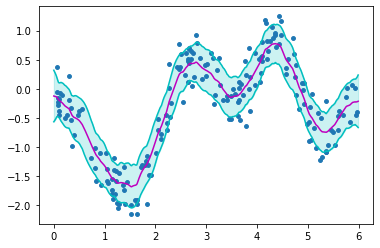

100
kernel lengthscale: 0.89
kernel variance: 0.35
Exact model log p(y): -155.90


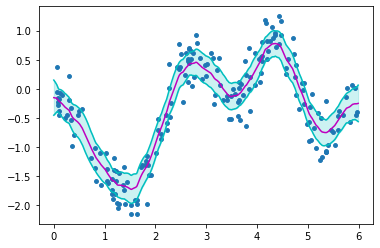

200
kernel lengthscale: 1.20
kernel variance: 0.39
Exact model log p(y): -100.44


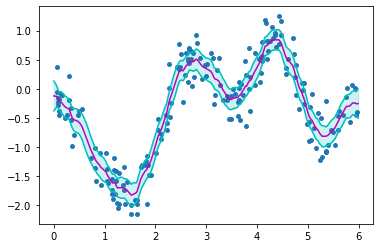

300
kernel lengthscale: 1.42
kernel variance: 0.44
Exact model log p(y): -73.39


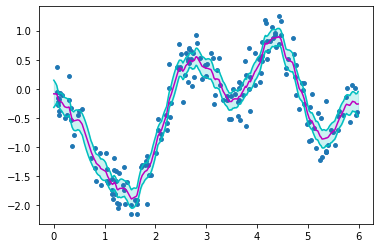

400
kernel lengthscale: 1.55
kernel variance: 0.51
Exact model log p(y): -68.61


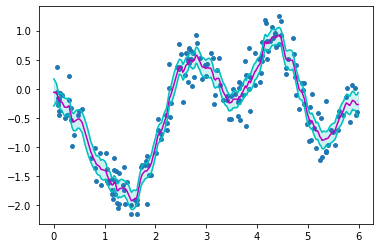

Exact model log p(y): -68.32


In [11]:

kernel = gpflow.kernels.Matern12(variance=0.5, lengthscales=0.5)
likelihood = gpflow.likelihoods.Gaussian()

exactModel = gpflow.models.GPR( (X, Y), kernel )

gpflow.utilities.set_trainable(kernel.lengthscales, True)
gpflow.utilities.set_trainable(kernel.variance, True)

optimizer = tf.optimizers.Adam(learning_rate=0.01)

@tf.function
def loss_closure():
  return -exactModel.log_marginal_likelihood()

Xtest = np.arange(0.0, 6.0, 0.01).reshape(-1, 1)

for i in range(500):
  if i % 100 == 0:
    print(i)
    print("kernel lengthscale: %2.2f" % kernel.lengthscales.read_value())
    print("kernel variance: %2.2f" % kernel.variance.read_value())
    print("Exact model log p(y): %2.2f" % exactModel.log_marginal_likelihood() )

    mean, std = exactModel.predict_f(Xtest, False, False)
    std = tf.sqrt(std)
    plot(Xtest, [(mean, std, 'm', 'c')])

  optimizer.minimize( loss=loss_closure, var_list=exactModel.trainable_variables )

print("Exact model log p(y): %2.2f" % exactModel.log_marginal_likelihood() )

###We now use approximate inference with Random Variational Fourier Features

kernel lengthscale: 0.70
kernel variance: 1.00
ELBO: -219.58


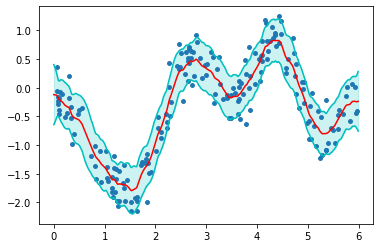

kernel lengthscale: 0.81
kernel variance: 1.00
ELBO: -208.11


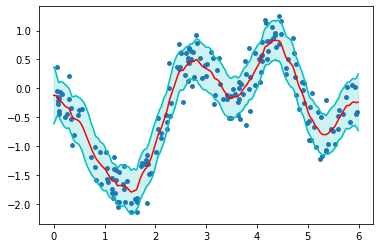

kernel lengthscale: 0.92
kernel variance: 1.00
ELBO: -196.26


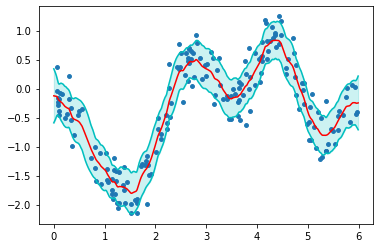

kernel lengthscale: 1.04
kernel variance: 1.00
ELBO: -184.05


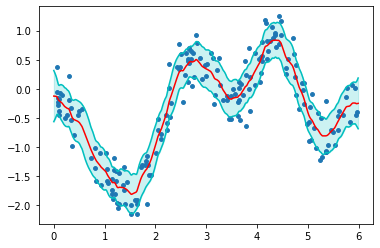

kernel lengthscale: 1.16
kernel variance: 1.00
ELBO: -171.58


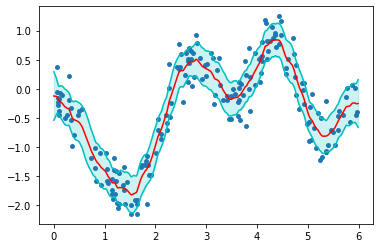

kernel lengthscale: 1.28
kernel variance: 1.00
ELBO: -159.02


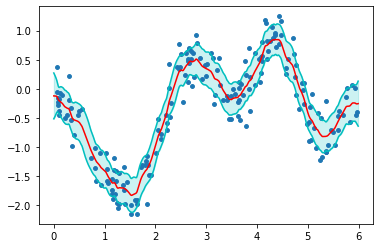

kernel lengthscale: 1.41
kernel variance: 1.00
ELBO: -146.57


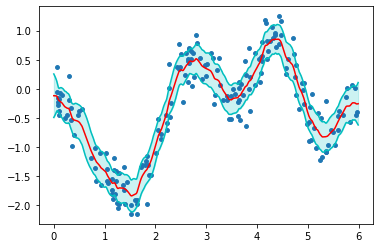

kernel lengthscale: 1.54
kernel variance: 1.00
ELBO: -134.49


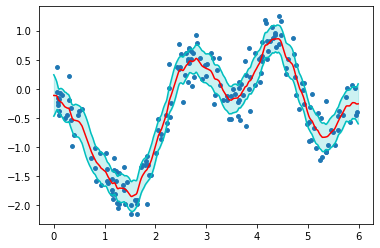

kernel lengthscale: 1.66
kernel variance: 1.00
ELBO: -123.02


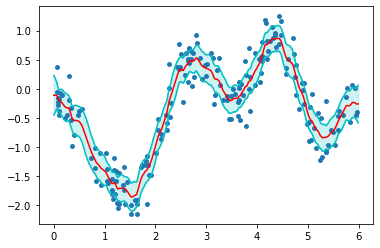

kernel lengthscale: 1.79
kernel variance: 1.00
ELBO: -112.45


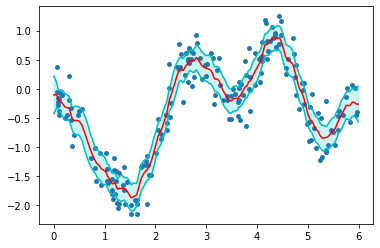

kernel lengthscale: 1.92
kernel variance: 1.00
ELBO: -102.96


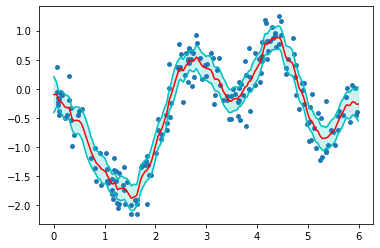

kernel lengthscale: 2.05
kernel variance: 1.00
ELBO: -94.77


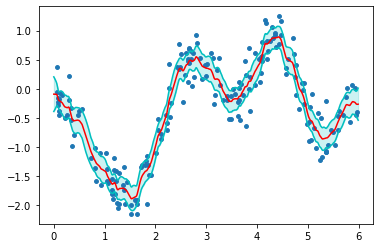

kernel lengthscale: 2.17
kernel variance: 1.00
ELBO: -87.97


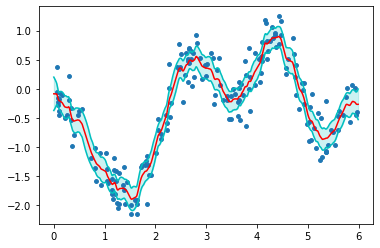

kernel lengthscale: 2.28
kernel variance: 1.00
ELBO: -82.56


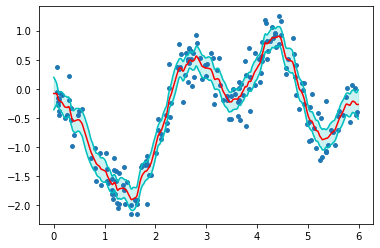

kernel lengthscale: 2.39
kernel variance: 1.00
ELBO: -78.50


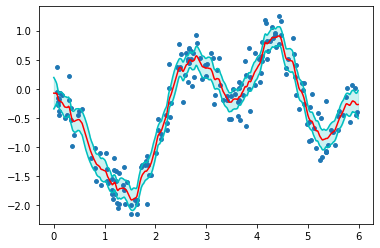

kernel lengthscale: 2.50
kernel variance: 1.00
ELBO: -75.59


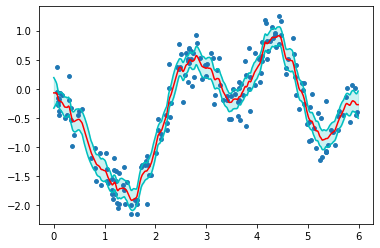

kernel lengthscale: 2.59
kernel variance: 1.00
ELBO: -73.58


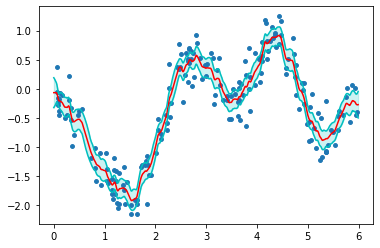

kernel lengthscale: 2.67
kernel variance: 1.00
ELBO: -72.32


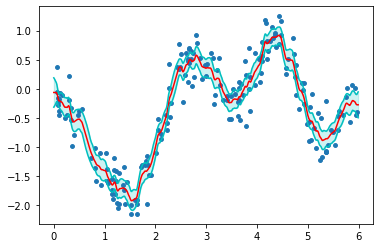

kernel lengthscale: 2.75
kernel variance: 1.00
ELBO: -71.54


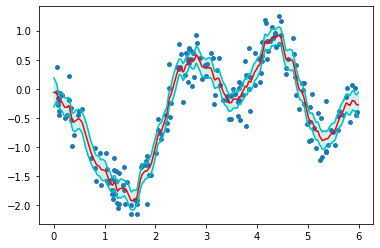

kernel lengthscale: 2.82
kernel variance: 1.00
ELBO: -71.08


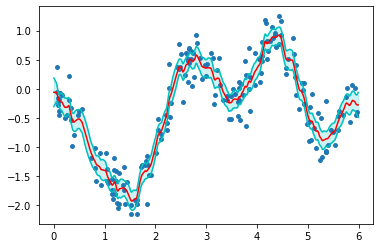

kernel lengthscale: 2.88
kernel variance: 1.00
ELBO: -70.85


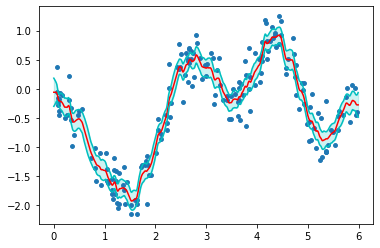

kernel lengthscale: 2.93
kernel variance: 1.00
ELBO: -70.69


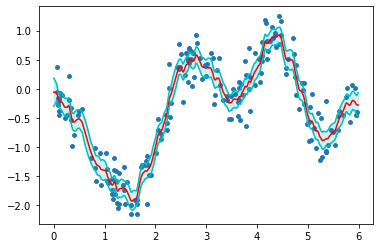

kernel lengthscale: 2.98
kernel variance: 1.00
ELBO: -70.62


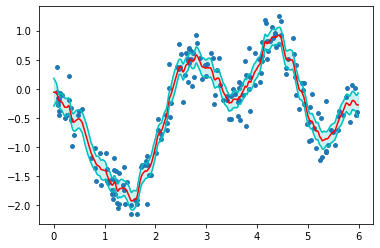

kernel lengthscale: 3.02
kernel variance: 1.00
ELBO: -70.59


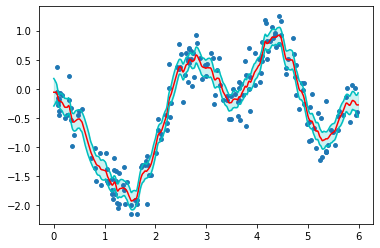

kernel lengthscale: 3.06
kernel variance: 1.00
ELBO: -70.52


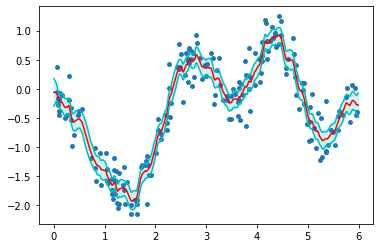

Variational Model ELBO is -70.50


In [120]:
tf.config.experimental_run_functions_eagerly(True)

M = 300
inducing_variable = RVFF_1D( a=0, b=6, M=M )

kernel2 = gpflow.kernels.Matern12(variance=1.0, lengthscales=0.7)

model = gpflow.models.SGPR(
    (X, Y), kernel=kernel2, inducing_variable=inducing_variable
)

optimizer = tf.optimizers.Adam(learning_rate=0.01)

gpflow.set_trainable(kernel2.variance, False)
gpflow.set_trainable(kernel2.lengthscales, True)
gpflow.set_trainable(likelihood, False)
gpflow.set_trainable(model.inducing_variable.a, False)
gpflow.set_trainable(model.inducing_variable.b, False)
gpflow.set_trainable(model.inducing_variable.phis, True)
gpflow.set_trainable(model.inducing_variable.omegas, True)

@tf.function
def loss_closure():
  return -model.elbo()

# Compute the gradients for a list of variables.
# with tf.GradientTape() as tape:
#   loss = loss_closure()
# var_list = model.trainable_parameters
# grads = tape.gradient(loss, var_list)

# print(grads)

# Ask the optimizer to apply the processed gradients.
# optimizer.apply_gradients(zip(grads, var_list))

for i in range(500):
  if i % 20 == 0:
    print("kernel lengthscale: %2.2f" % kernel2.lengthscales.read_value())
    print("kernel variance: %2.2f" % kernel2.variance.read_value())
    print("ELBO: %2.2f" % model.elbo() )

    mean, std = model.predict_f(Xtest, False, False)
    std = tf.sqrt(std)
    plot(Xtest, [(mean, std, 'r', 'c')])

  optimizer.minimize( loss=loss_closure, var_list=model.trainable_variables )

print( "Variational Model ELBO is %3.2f" % model.elbo() )

#Testing

###Plotting a posterior sample on top of the scatter plot of the data:

In [0]:
with open('./model', 'wb') as fp:
    pickle.dump(model.trainable_parameters, fp)
    pickle.dump(inducing_variable.omegas, fp)
    pickle.dump(inducing_variable.phis, fp)

In [0]:
with open('./model', 'rb') as fp:
    param_dict = pickle.load(fp)
    omegas = pickle.load(fp)
    phis = pickle.load(fp)

M = 300

inducing_variable = RVFF_1D( a=0, b=6, M=M )
inducing_variable.omegas = omegas
inducing_variable.phis = phis

model = gpflow.models.SGPR((X, Y), kernel=kernel, inducing_variable=inducing_variable)

gpflow.utilities.set_trainable(kernel.lengthscales, False)
gpflow.utilities.set_trainable(kernel.variance, False)
gpflow.utilities.set_trainable(inducing_variable.a, False)
gpflow.utilities.set_trainable(inducing_variable.b, False)

if len(model.trainable_parameters) == len(param_dict):
  for i in range(len(model.trainable_parameters)):
    model.trainable_parameters[i].assign(param_dict[i])

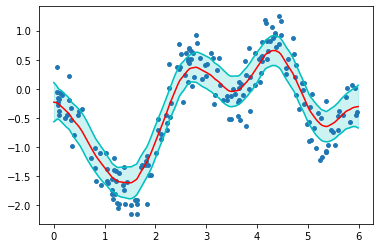

ELBO of SGPR model is -213.43
log( p( Y | θ ) ) of exact GP is -68.32


In [15]:
mean, std = model.predict_f(Xtest, False, False)
std = tf.sqrt(std)
plot(Xtest, [(mean, std, 'r', 'c')])

print("ELBO of SGPR model is %4.2f" % model.elbo().numpy())
print("log( p( Y | θ ) ) of exact GP is %4.2f" % exactModel.log_marginal_likelihood().numpy())

Testing whether the model is the equivalent to Variational Fourier Features when the frequencies and phases are set manually to correspond to multiples of the base frequency, and not optimised as variational parameters. 

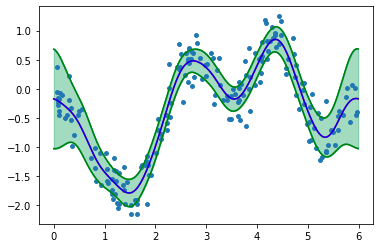

If you can only see one mean function and one error bar, VFF and RVFF perfectly coincide.
RVFF model ELBO is -236.12
VFF model ELBO is -236.12
Test passed!


In [90]:
def testFeatureequivalence(tol):
  VFFlength = 10
  RVFFlength = 2 * VFFlength - 1

  VFFinducingVar = VFF_IV.FourierFeatures1D(0, 6, VFFlength)
  VFFmodel = gpflow.models.SGPR((X, Y), kernel2, VFFinducingVar)

  RVFFinducingVar = RVFF_1D(0, 6, RVFFlength)

  RVFFfrequencies = tf.concat( ( VFFinducingVar.omegas, tf.reshape( tf.gather( VFFinducingVar.omegas, tf.where( VFFinducingVar.omegas != 0.0 ) ), [-1] ) ), axis=0 )
  RVFFphases = tf.concat( ( np.pi / ( 2 * VFFinducingVar.omegas[1:VFFlength] ), tf.zeros(RVFFlength - VFFlength, dtype=default_float()) ), axis=0 )
  RVFFphases = tf.concat( ( tf.constant([ np.pi / 2 ], dtype=default_float()), RVFFphases ), axis=0 )

  RVFFinducingVar.omegas.assign( RVFFfrequencies )
  RVFFinducingVar.phis.assign( RVFFphases )

  RVFFmodel = gpflow.models.SGPR((X, Y), kernel2, RVFFinducingVar)
    
  meanVFF, covVFF = VFFmodel.predict_f(Xtest, True, False)
  meanRVFF, covRVFF = RVFFmodel.predict_f(Xtest, True, False)
  
  plot(Xtest, [(meanVFF, tf.transpose(tf.linalg.diag_part(covVFF)), 'r', 'c'), (meanRVFF, tf.transpose(tf.linalg.diag_part(covRVFF)), 'b', 'g')])
  print("If you can only see one mean function and one error bar, VFF and RVFF perfectly coincide.")

  print("RVFF model ELBO is %2.2f" % RVFFmodel.elbo())
  print("VFF model ELBO is %2.2f" % VFFmodel.elbo())

  return tf.math.reduce_sum(tf.math.abs(covRVFF-covVFF)) < tol and tf.math.reduce_sum(tf.math.abs(meanRVFF-meanVFF)) < tol

str = "Test passed!" if testFeatureequivalence(10e-2) else "Test failed."
print(str)

Testing whether $q(u) = p(u)$ when we fix q_sqrt = cholesky($K_{uu}$)

In [17]:
kernel = gpflow.kernels.Matern12(variance=5, lengthscales=10.0)
likelihood = gpflow.likelihoods.Gaussian()

M = 200

inducing_variable = RVFF_1D( a=0, b=6, M=M )

def testPriorEqualsPosterior():
  M = 200
  model = gpflow.models.SVGP(
      kernel=kernel, likelihood=likelihood, inducing_variable=inducing_variable
  )
  q_sqrt = tf.linalg.cholesky( Kuu_matern12_RVFF_1D(model.inducing_variable, model.kernel) )

  return model.prior_kl()

print( "KL[ q(u) | p(u) ] = %2.3f" % testPriorEqualsPosterior() )

KL[ q(u) | p(u) ] = 0.000


Testing whether $K_{uu}$ is computed correctly with Monte-Carlo integration:

In [86]:
def grid_search_integrate(f, bound1, bound2, numOfSamples):
  samples = tf.range(bound1, bound2, ( bound2 - bound1 ) / float(numOfSamples))
  V = tf.math.reduce_prod( bound2 - bound1 )

  return V * tf.math.reduce_sum( f( samples ) ) / numOfSamples

def mattern_half_inner_product_integrand(f, g, df, dg, lambda_):
  def evaluate_on(x):
    return ( lambda_ * f(x) + df(x) ) * ( lambda_ * g(x) + dg(x) )
  return evaluate_on

def grid_search_mattern_half_inner_prod( sigma, lambda_, a, b, omega1, phi1, omega2, phi2 ):
  f = sin(omega1, a, phi1)
  g = sin(omega2, a, phi2)
  
  df = dsin(omega1, a, phi1)
  dg = dsin(omega2, a, phi2)

  integral = grid_search_integrate(
      mattern_half_inner_product_integrand(f, g, df, dg, lambda_),
      a,
      b,
      10e6
  )

  term1 = integral / ( 2 * lambda_ * sigma * sigma )
  term2 = f(a) * g(a) / (sigma * sigma)

  return term1 + term2

def sin( omega, a, phi ):
  def compute_sin(x):
    return tf.sin( omega * ( x - a + phi ) )
  return compute_sin

def dsin( omega, a, phi ):
  def compute_dsin(x):
    return omega * tf.cos( omega * ( x - a + phi ) )
  return compute_dsin

def test_Kuu_evaluation(inducing_variable, kernel, tol):
  analyticKuu = gpflow.covariances.Kuu(inducing_variable, kernel)
  numericalKuu = np.empty((len(inducing_variable), len(inducing_variable)))

  a, b, omegas, phis = (lambda u: (u.a, u.b, u.omegas, u.phis)) (inducing_variable)  
  lambda_, sigma = (lambda k: (1/k.lengthscales, k.variance))(kernel)

  for i in range(len(inducing_variable)):
    for j in range(len(inducing_variable)):
      numericalKuu[i, j] = grid_search_mattern_half_inner_prod(sigma, lambda_, a, b, omegas[i], phis[i], omegas[j], phis[j])

  print(analyticKuu)
  print(numericalKuu)

  return True if tf.reduce_all( abs(analyticKuu - numericalKuu) < tol ) else False

str = "Test passed!" if test_Kuu_evaluation(RVFF_1D(0, 6, 2), gpflow.kernels.Matern12(), 10e-3) else "Test failed."
print(str)

tf.Tensor(
[[8.27534297e+03 3.18364566e+01]
 [3.18364566e+01 3.30631282e+04]], shape=(2, 2), dtype=float64)
[[8.27534338e+03 3.18351318e+01]
 [3.18351318e+01 3.30631315e+04]]
Test passed!


Testing whether the predictive covariance $K_{ff}$ is positive semidefinite.

In [23]:
def is_psd(matrix, tol):
  return tf.reduce_all(tf.linalg.eigh(matrix)[0] > tol)

def test_predictive_cov_is_psd(model):
  Xtest = np.arange(0, 6, 0.05).reshape(-1, 1)
  predictive_cov = tf.squeeze( model.predict_f(X, True, False)[1] )
  return is_psd(predictive_cov, -1e-1)

str = "True" if test_predictive_cov_is_psd(model) else "False"
print( "predictive_cov is psd: " + str )

predictive_cov is psd: True


# Feature comparison with Variational Fourier Features

Iteration  0
Kernel lengthscale: 0.70
Kernel variance: 1.00
VFF model ELBO: -224.60


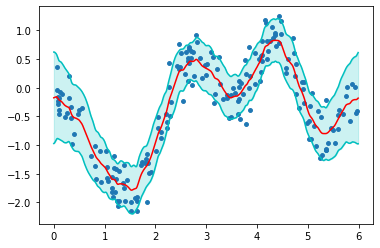

Iteration 20
Kernel lengthscale: 0.80
Kernel variance: 0.88
VFF model ELBO: -212.72


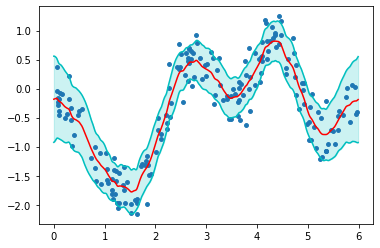

Iteration 40
Kernel lengthscale: 0.88
Kernel variance: 0.77
VFF model ELBO: -200.69


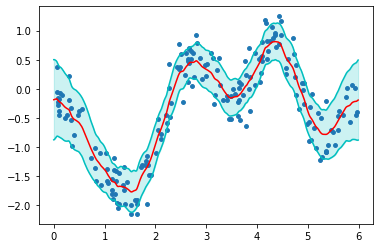

Iteration 60
Kernel lengthscale: 0.93
Kernel variance: 0.66
VFF model ELBO: -188.42


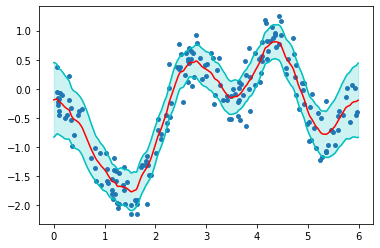

Iteration 80
Kernel lengthscale: 0.92
Kernel variance: 0.57
VFF model ELBO: -175.94


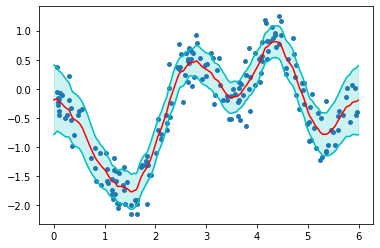

Iteration 100
Kernel lengthscale: 0.88
Kernel variance: 0.49
VFF model ELBO: -163.42


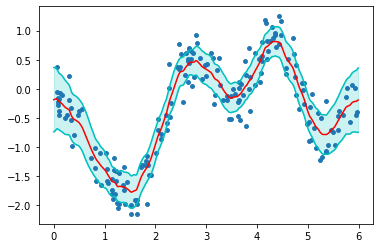

Iteration 120
Kernel lengthscale: 0.84
Kernel variance: 0.43
VFF model ELBO: -151.09


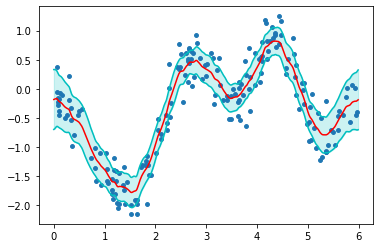

Iteration 140
Kernel lengthscale: 0.79
Kernel variance: 0.37
VFF model ELBO: -139.28


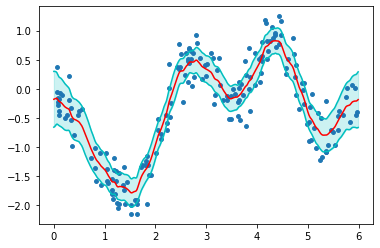

Iteration 160
Kernel lengthscale: 0.76
Kernel variance: 0.32
VFF model ELBO: -128.30


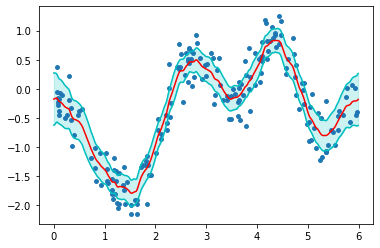

Iteration 180
Kernel lengthscale: 0.73
Kernel variance: 0.28
VFF model ELBO: -118.43


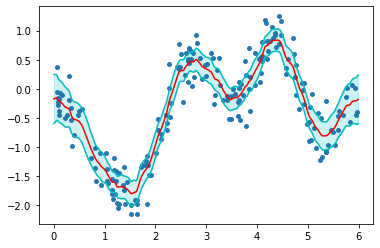

Iteration 200
Kernel lengthscale: 0.70
Kernel variance: 0.25
VFF model ELBO: -109.91


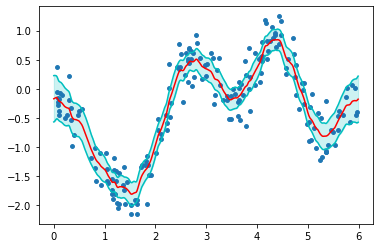

Iteration 220
Kernel lengthscale: 0.68
Kernel variance: 0.23
VFF model ELBO: -102.88


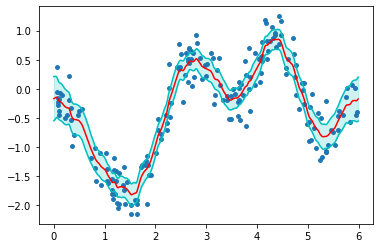

Iteration 240
Kernel lengthscale: 0.66
Kernel variance: 0.21
VFF model ELBO: -97.36


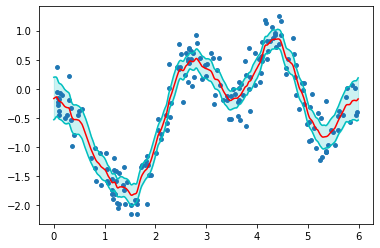

Iteration 260
Kernel lengthscale: 0.64
Kernel variance: 0.20
VFF model ELBO: -93.27


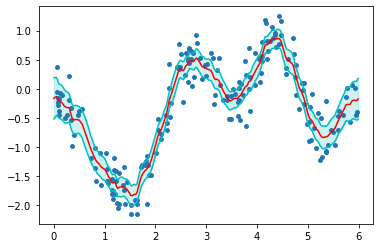

Iteration 280
Kernel lengthscale: 0.62
Kernel variance: 0.19
VFF model ELBO: -90.43


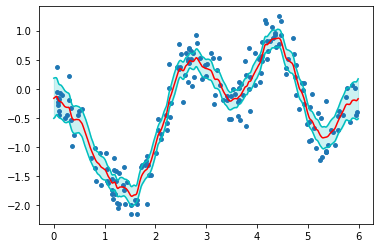

Iteration 300
Kernel lengthscale: 0.61
Kernel variance: 0.18
VFF model ELBO: -88.58


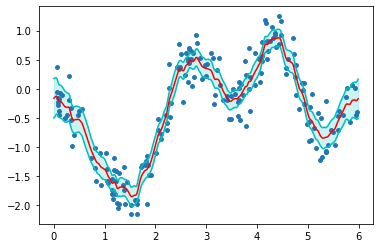

Iteration 320
Kernel lengthscale: 0.61
Kernel variance: 0.18
VFF model ELBO: -88.25


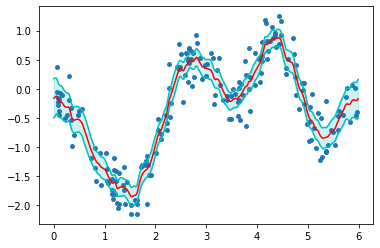

Iteration 340
Kernel lengthscale: 0.60
Kernel variance: 0.18
VFF model ELBO: -87.94


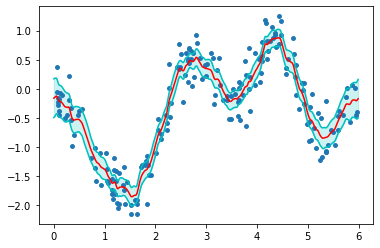

Iteration 360
Kernel lengthscale: 0.60
Kernel variance: 0.18
VFF model ELBO: -87.67


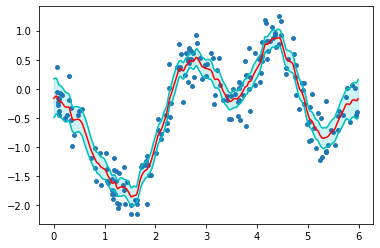

Iteration 380
Kernel lengthscale: 0.60
Kernel variance: 0.17
VFF model ELBO: -87.41


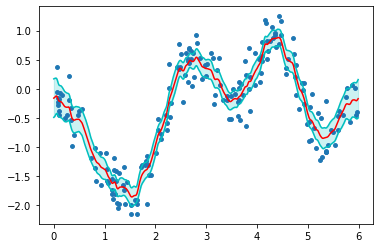

Iteration 400
Kernel lengthscale: 0.59
Kernel variance: 0.17
VFF model ELBO: -87.18


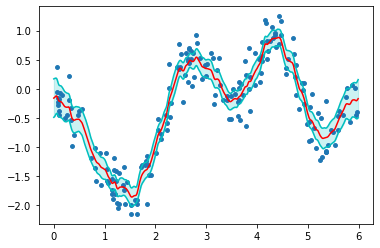

Iteration 420
Kernel lengthscale: 0.59
Kernel variance: 0.17
VFF model ELBO: -86.98


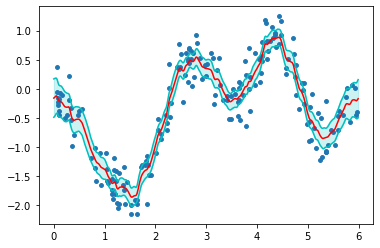

Iteration 440
Kernel lengthscale: 0.59
Kernel variance: 0.17
VFF model ELBO: -86.79


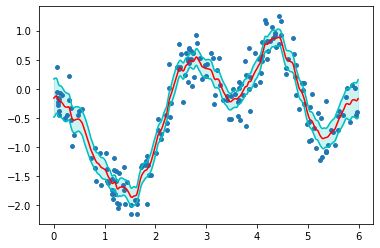

Iteration 460
Kernel lengthscale: 0.59
Kernel variance: 0.17
VFF model ELBO: -86.63


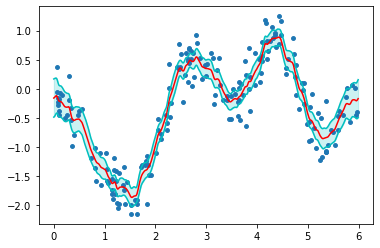

Iteration 480
Kernel lengthscale: 0.58
Kernel variance: 0.17
VFF model ELBO: -86.50


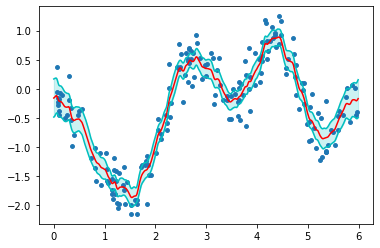

Iteration 500
Kernel lengthscale: 0.58
Kernel variance: 0.17
VFF model ELBO: -86.39


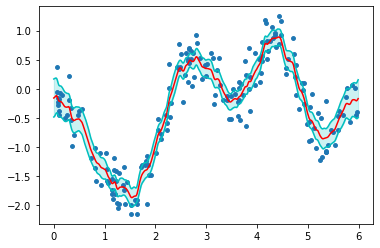

Iteration 520
Kernel lengthscale: 0.58
Kernel variance: 0.17
VFF model ELBO: -86.30


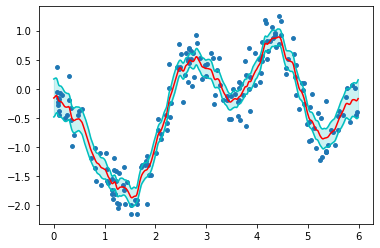

Iteration 540
Kernel lengthscale: 0.58
Kernel variance: 0.17
VFF model ELBO: -86.24


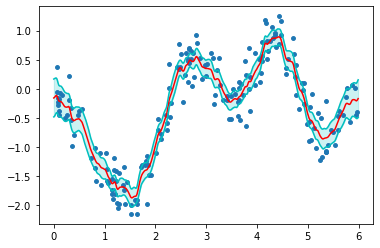

Iteration 560
Kernel lengthscale: 0.57
Kernel variance: 0.17
VFF model ELBO: -86.21


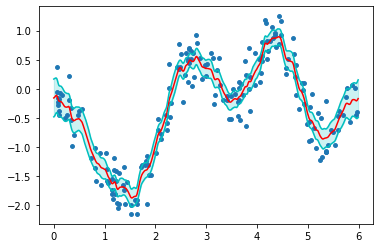

Iteration 580
Kernel lengthscale: 0.57
Kernel variance: 0.17
VFF model ELBO: -86.19


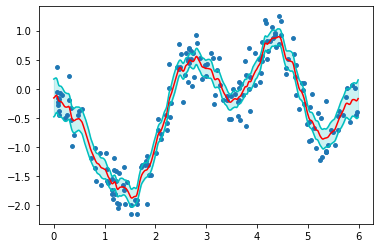

Iteration 600
Kernel lengthscale: 0.57
Kernel variance: 0.17
VFF model ELBO: -86.19


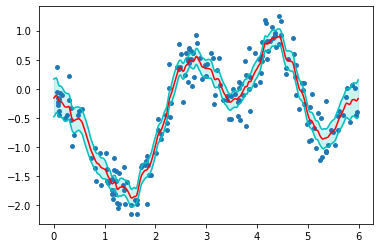

Iteration 620
Kernel lengthscale: 0.57
Kernel variance: 0.17
VFF model ELBO: -86.19


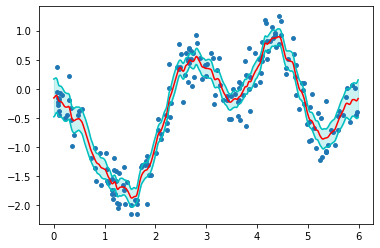

Iteration 640
Kernel lengthscale: 0.57
Kernel variance: 0.17
VFF model ELBO: -86.19


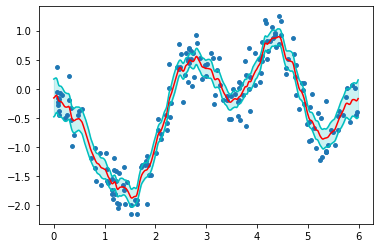

Iteration 660
Kernel lengthscale: 0.57
Kernel variance: 0.17
VFF model ELBO: -86.19


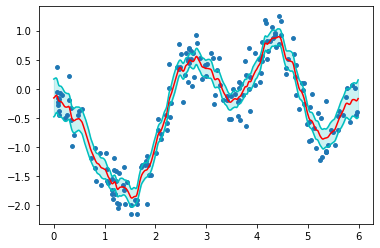

Iteration 680
Kernel lengthscale: 0.57
Kernel variance: 0.17
VFF model ELBO: -86.19


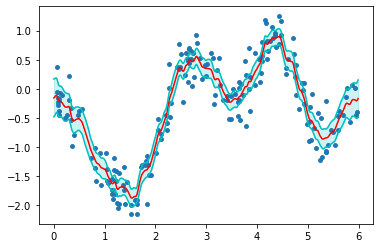

Iteration 700
Kernel lengthscale: 0.57
Kernel variance: 0.17
VFF model ELBO: -86.19


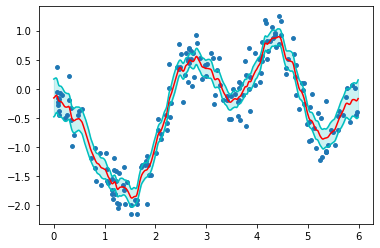

Iteration 720
Kernel lengthscale: 0.57
Kernel variance: 0.17
VFF model ELBO: -86.19


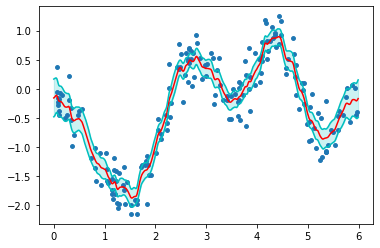

Iteration 740
Kernel lengthscale: 0.57
Kernel variance: 0.17
VFF model ELBO: -86.19


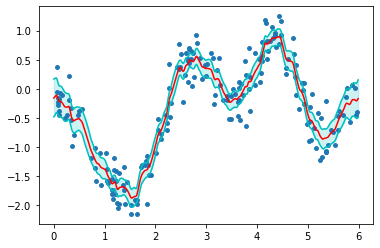

Iteration 760
Kernel lengthscale: 0.57
Kernel variance: 0.17
VFF model ELBO: -86.19


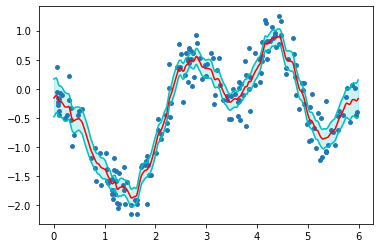

Iteration 780
Kernel lengthscale: 0.57
Kernel variance: 0.17
VFF model ELBO: -86.19


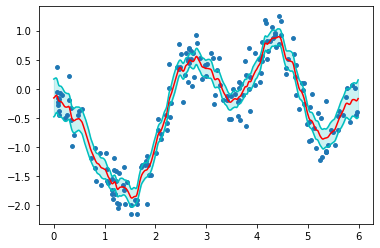

Iteration 800
Kernel lengthscale: 0.57
Kernel variance: 0.17
VFF model ELBO: -86.19


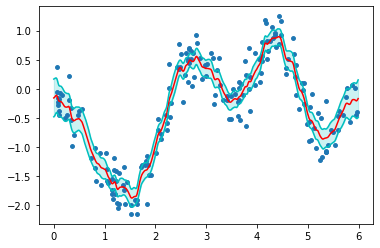

Iteration 820
Kernel lengthscale: 0.57
Kernel variance: 0.17
VFF model ELBO: -86.19


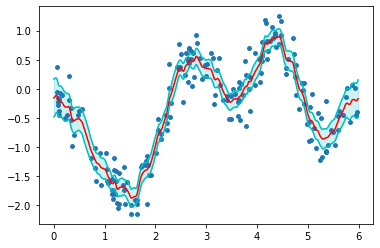

Iteration 840
Kernel lengthscale: 0.57
Kernel variance: 0.17
VFF model ELBO: -86.19


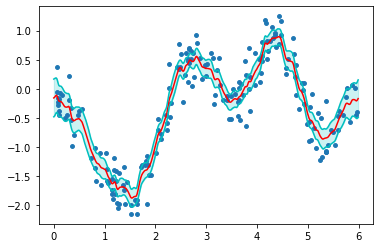

Iteration 860
Kernel lengthscale: 0.57
Kernel variance: 0.17
VFF model ELBO: -86.19


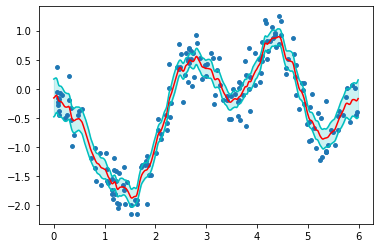

Iteration 880
Kernel lengthscale: 0.57
Kernel variance: 0.17
VFF model ELBO: -86.19


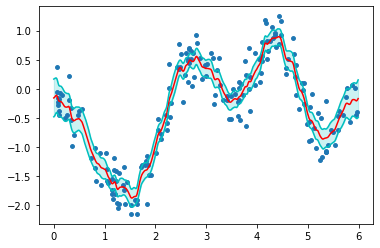

Iteration 900
Kernel lengthscale: 0.57
Kernel variance: 0.17
VFF model ELBO: -86.19


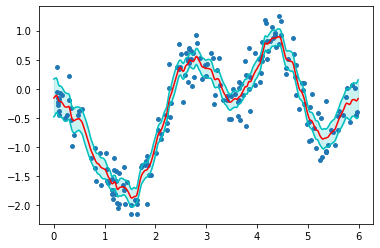

Iteration 920
Kernel lengthscale: 0.57
Kernel variance: 0.17
VFF model ELBO: -86.19


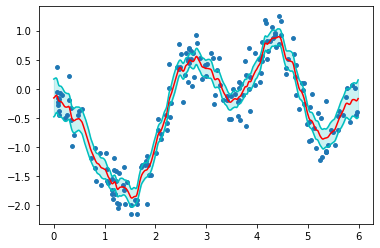

Iteration 940
Kernel lengthscale: 0.57
Kernel variance: 0.17
VFF model ELBO: -86.19


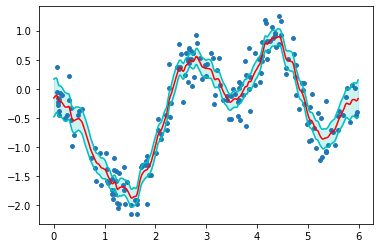

KeyboardInterrupt: ignored

In [130]:
VFFlength = 100
RVFFlength = 2 * VFFlength - 1

kernel2 = gpflow.kernels.Matern12(variance=1.0, lengthscales=0.7)

VFFinducingVar = VFF_IV.FourierFeatures1D(0, 6, VFFlength)
VFFmodel = gpflow.models.SGPR((X, Y), kernel2, VFFinducingVar)

RVFFinducingVar = RVFF_1D(0, 6, RVFFlength)

RVFFfrequencies = tf.concat( ( VFFinducingVar.omegas, tf.reshape( tf.gather( VFFinducingVar.omegas, tf.where( VFFinducingVar.omegas != 0.0 ) ), [-1] ) ), axis=0 )
RVFFphases = tf.concat( ( np.pi / ( 2 * VFFinducingVar.omegas[1:VFFlength] ), tf.zeros(RVFFlength - VFFlength, dtype=default_float()) ), axis=0 )
RVFFphases = tf.concat( ( tf.constant([ np.pi / 2 ], dtype=default_float()), RVFFphases ), axis=0 )

RVFFinducingVar.omegas.assign( RVFFfrequencies )
RVFFinducingVar.phis.assign( RVFFphases )
RVFFmodel = gpflow.models.SGPR((X, Y), kernel2, RVFFinducingVar)

optimizer = tf.optimizers.Adam(learning_rate=0.01)

gpflow.set_trainable(kernel2.variance, True)
gpflow.set_trainable(kernel2.lengthscales, True)

gpflow.set_trainable(RVFFmodel.inducing_variable.a, False)
gpflow.set_trainable(RVFFmodel.inducing_variable.b, False)
gpflow.set_trainable(RVFFmodel.inducing_variable.phis, True)
gpflow.set_trainable(RVFFmodel.inducing_variable.omegas, True)
gpflow.set_trainable(RVFFmodel.likelihood, True)

gpflow.set_trainable(VFFmodel.inducing_variable.a, False)
gpflow.set_trainable(VFFmodel.inducing_variable.b, False)
gpflow.set_trainable(VFFmodel.likelihood, True)

@tf.function
def loss_closure_RVFF():
  return -RVFFmodel.elbo()

@tf.function
def loss_closure_VFF():
  return -VFFmodel.elbo()

# Compute the gradients for a list of variables.
# with tf.GradientTape() as tape:

# var_list = RVFFmodel.trainable_parameters
# grads = tape.gradient(loss, var_list)

# print("th gradients are:")
# print(grads)

# Ask the optimizer to apply the processed gradients.
# optimizer.apply_gradients(zip(grads, var_list))

for i in range(1000):
  if i % 20 == 0:
    print("Iteration %2d" % i)
    print("Kernel lengthscale: %2.2f" % kernel2.lengthscales.read_value() )
    print("Kernel variance: %2.2f" % kernel2.variance.read_value() )
    # print("RVFF model ELBO: %2.2f" % RVFFmodel.elbo() )
    print("VFF model ELBO: %2.2f" % VFFmodel.elbo() )

    # mean, std = RVFFmodel.predict_f(Xtest, False, False)
    mean, std = VFFmodel.predict_f(Xtest, False, False)
    std = tf.sqrt(std)
    plot(Xtest, [(mean, std, 'r', 'c')])

  # optimizer.minimize( loss=loss_closure_RVFF, var_list=RVFFmodel.trainable_variables )
  optimizer.minimize( loss=loss_closure_VFF, var_list=VFFmodel.trainable_variables )

# print( "Variational Model ELBO is %3.2f" % RVFFmodel.elbo() )
print( "Variational Model ELBO is %3.2f" % VFFmodel.elbo() )